In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, auc
from IPython.display import clear_output
import os
import shutil
import re
from datetime import datetime, timedelta

In [180]:
# Load the original data
X = np.load('../ctg_dataset/X.npy')
y = np.load('../ctg_dataset/y.npy')
dataset = pd.read_csv('../ctg_dataset/clinical_data.csv')

print(X.shape)
print(y.shape)
print(dataset.shape)

(20589, 960, 2)
(20589,)
(20589, 7)


In [181]:
# Manually set results_dir if needed 
results_dir = None 

# Set results_dir to the most recent one
if results_dir is None:
    subdirs = [d for d in os.listdir('PatchTST_supervised/jResults/') if os.path.isdir(os.path.join('PatchTST_supervised/jResults/', d))]
    valid_dirs = []
    for subdir in subdirs:
        try:
            datetime.strptime(subdir, '%Y%m%d %H%M')
            valid_dirs.append(subdir)
        except ValueError:
            continue
    valid_dirs_sorted = sorted(valid_dirs, key=lambda x: datetime.strptime(x, '%Y%m%d %H%M'))
    if valid_dirs_sorted:
        results_dir = os.path.join('PatchTST_supervised/jResults/', valid_dirs_sorted[-1])
print(results_dir)

# Load the split dataset, logs and results 
train_df = pd.read_csv(os.path.join(results_dir, 'dataset_train.csv'))
test_df = pd.read_csv(os.path.join(results_dir, 'dataset_test.csv'))
preds = np.load(os.path.join(results_dir, 'preds.npy'))
trues = np.load(os.path.join(results_dir, 'trues.npy'))
with open(os.path.join(results_dir, 'PatchTST_ctg_960.log'), 'r') as log_file:
    log_data = log_file.read()

PatchTST_supervised/jResults/20240828 1840


In [182]:
def print_stats(df, label):
    # Function to print stats for a given dataset
    print(f"-------------------- Label {label} --------------------")
    df = df[df['label'] == label]
    count = len(df)
    print(f"Count: {count}")
    
    for col in ['OMAGE', 'OPAR1', 'OPAR2', 'RecGest', 'Diff', 'BMI_M', 'OSEX']:
        if df[col].dtype == 'object' or len(df[col].unique()) <= 10:
            unique_values = df[col].unique()
            print(f"{col}: {len(unique_values)} unique values ({', '.join(map(str, unique_values))})")
        else:
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            print(f"{col}: {min_val:.2f} - {max_val:.2f} (Mean: {mean_val:.2f})")

print(f"\n==================== Train Set ====================")
print_stats(train_df, 0)
print_stats(train_df, 1) 
print(f"\n==================== Test Set  ====================")
print_stats(test_df, 0)
print_stats(test_df, 1) 


==================== Train Set ====================
-------------------- Label 0 --------------------
Count: 8684
OMAGE: 18.00 - 49.00 (Mean: 30.60)
OPAR1: 7 unique values (1.0, 0.0, 2.0, 3.0, 6.0, 5.0, 4.0)
OPAR2: 10 unique values (2.0, 0.0, 1.0, 3.0, 5.0, 4.0, 7.0, 6.0, 14.0, 8.0)
RecGest: 27.00 - 41.00 (Mean: 34.86)
Diff: 1.00 - 2618.00 (Mean: 681.27)
BMI_M: 15.55 - 40.00 (Mean: 25.71)
OSEX: 2 unique values (1.0, 0.0)
-------------------- Label 1 --------------------
Count: 7787
OMAGE: 15.00 - 49.00 (Mean: 30.68)
OPAR1: 7 unique values (0.0, 2.0, 1.0, 3.0, 4.0, 6.0, 5.0)
OPAR2: 10 unique values (1.0, 0.0, 2.0, 3.0, 5.0, 4.0, 7.0, 6.0, nan, 9.0)
RecGest: 27.00 - 41.00 (Mean: 34.77)
Diff: 0.00 - 168.00 (Mean: 61.87)
BMI_M: 15.42 - 39.82 (Mean: 26.01)
OSEX: 2 unique values (1.0, 0.0)

==================== Test Set  ====================
-------------------- Label 0 --------------------
Count: 2206
OMAGE: 18.00 - 48.00 (Mean: 30.66)
OPAR1: 7 unique values (0.0, 2.0, 1.0, 3.0, 5.0, 4.0, 

******************** Hyperparameters ********************
activation: gelu
affine: 0
batch_size: 64
c_out: 1
checkpoints: ./checkpoints/ctg
d_ff: 256
d_layers: 1
d_model: 128
data: CTG
data_path: X.npy
dec_in: 2
decomposition: 0
des: Exp
devices: 0,1,2,3
distil: True
do_predict: False
dropout: 0.4
e_layers: 3
embed: timeF
embed_type: 0
enc_in: 2
factor: 1
fc_dropout: 0.2
features: M
freq: h
gpu: 0
head_dropout: 0.0
individual: 0
is_training: 1
itr: 1
kernel_size: 25
learning_rate: 5e-05
loss: cross_entropy
lradj: type3
model: PatchTST
model_id: ctg_960
moving_avg: 25
n_heads: 16
num_classes: 2
num_workers: 10
output_attention: False
padding_patch: end
patch_len: 16
patience: 30
pct_start: 0.3
random_seed: 2021
revin: 1
root_path: ./dataset/
seq_len: 960
stride: 8
subtract_last: 0
target: OT
test_flop: False
train_epochs: 200
use_amp: False
use_gpu: True
use_multi_gpu: False

******************* Training Results ********************

Total Training Time: 0:36:03.800773


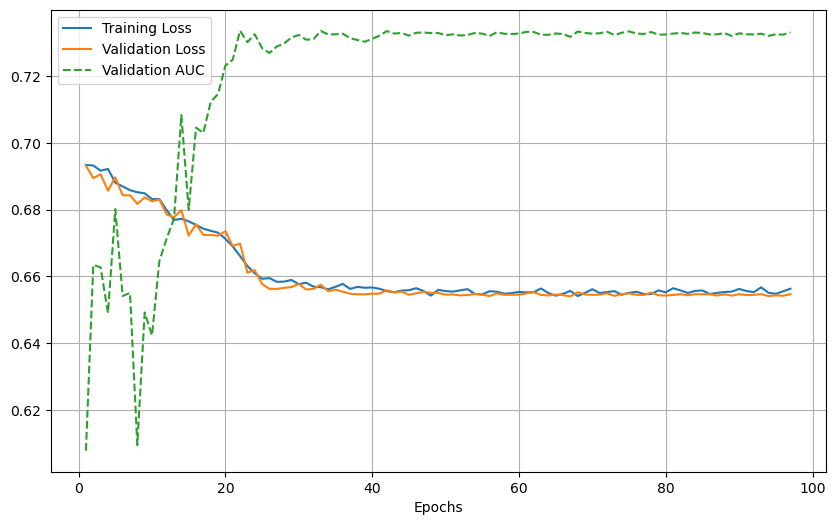


******************** Testing Results ********************
Accuracy: 0.65
Precision: 0.88
Recall: 0.29
F1 Score: 0.43
AUC: 0.73


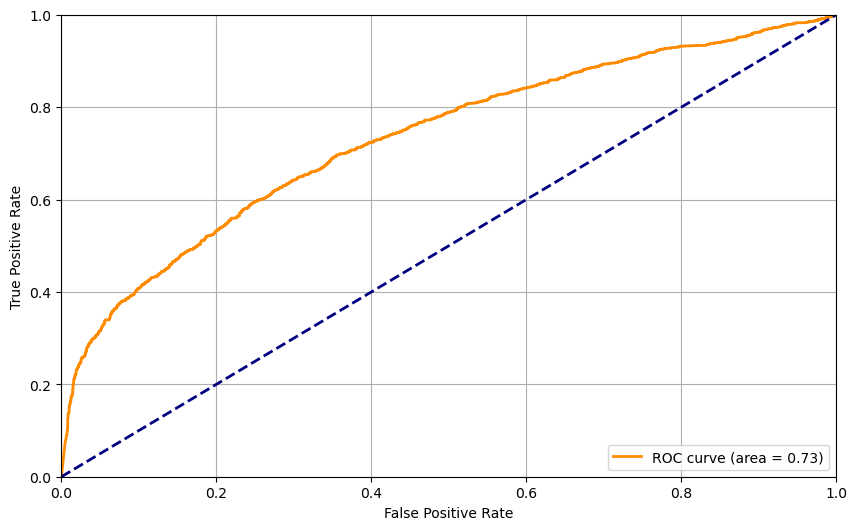

In [183]:
# Initialize variables to store log data
hyperparameters = {}
train_losses = []
val_losses = []
val_aucs = []
epochs = []
train_times = []
test_metrics = None

# Parse the log data directly from the variable
lines = log_data.splitlines()
for i, line in enumerate(lines):
    if i == 1 and line.startswith("Namespace("):
        hyperparameter_string = line.strip().replace("Namespace(", "").replace(")", "")
        hyperparameter_pairs = hyperparameter_string.split(", ")
        for item in hyperparameter_pairs:
            if "=" in item:
                key, value = item.split("=", 1)
                hyperparameters[key.strip()] = value.strip().strip("'")  # Remove quotes around string values

    # Extract training/validation losses and validation auc
    if "Train Loss" in line:
        match = re.findall(r'Epoch: (\d+).*Train Loss: ([\d.]+) Vali Loss: ([\d.]+) Vali AUC: ([\d.]+)', line)
        if match:
            epoch, train_loss, val_loss, val_auc = match[0]
            epochs.append(int(epoch))
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
            val_aucs.append(float(val_auc))
    
    # Extract training time
    if "cost time" in line:
        match = re.findall(r'Epoch: (\d+) cost time: ([\d.]+)', line)
        if match:
            epoch, time_taken = match[0]
            train_times.append(float(time_taken))
    
    # Extract final test metrics
    if "accuracy" in line:
        match = re.findall(r'accuracy:([\d.]+), precision:([\d.]+), recall:([\d.]+), f1:([\d.]+), auc:([\d.]+)', line)
        if match:
            accuracy, precision, recall, f1, auc_score = match[0]
            test_metrics = {
                'Accuracy': float(accuracy),
                'Precision': float(precision),
                'Recall': float(recall),
                'F1 Score': float(f1),
                'AUC': float(auc_score)
            }

print("******************** Hyperparameters ********************")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

print("\n******************* Training Results ********************")

# Calculate and print total training time
total_train_time = sum(train_times)
train_time_hms = str(timedelta(seconds=total_train_time))
print(f"\nTotal Training Time: {train_time_hms}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print the final test results
if test_metrics:
    print("\n******************** Testing Results ********************")
    for metric, value in test_metrics.items():
        print(f"{metric}: {np.round(value, decimals=2)}")

# Compute ROC curve and AUC using already loaded preds and trues
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [184]:
# Add the results to test_df
predicted_probs = preds.flatten()
predicted_labels = (predicted_probs > 0.5).astype(int)
test_df = test_df[:len(preds)]
test_df['predicted_prob'] = predicted_probs
test_df['predicted_label'] = predicted_labels

In [185]:
def calculate_stats(data, name):
    print(f"------ Stats of {name} ({len(data)}) -----")
    # Calculate min, max, mean specifically
    columns_of_interest = ['OMAGE', 'OPAR1', 'OPAR2', 'RecGest', 'Diff', 'BMI_M', 'OSEX']
    stats = data[columns_of_interest].agg(['min', 'max', 'mean']).round(2)
    print(stats)
    print("\n")

# Filtering by correctly classified and misclassified samples, as well as by label
correctly_classified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] == test_df['predicted_label'])]
correctly_classified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] == test_df['predicted_label'])]
misclassified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] != test_df['predicted_label'])]
misclassified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] != test_df['predicted_label'])]

calculate_stats(test_df, "All Test Samples")
calculate_stats(correctly_classified_cases, "Correctly Classified Cases")
calculate_stats(misclassified_cases, "Misclassified Cases")
calculate_stats(correctly_classified_controls, "Correctly Classified Controls")
calculate_stats(misclassified_controls, "Misclassified Controls")

------ Stats of All Test Samples (4118) -----
      OMAGE  OPAR1  OPAR2  RecGest     Diff  BMI_M  OSEX
min   16.00   0.00   0.00    27.00     0.00  15.73  0.00
max   48.00   6.00   8.00    41.00  2517.00  39.82  1.00
mean  30.71   0.74   0.48    34.79   398.45  25.89  0.48


------ Stats of Correctly Classified Cases (549) -----
      OMAGE  OPAR1  OPAR2  RecGest    Diff  BMI_M  OSEX
min   16.00   0.00   0.00    27.00    1.00  16.16  0.00
max   44.00   5.00   7.00    41.00  168.00  39.82  1.00
mean  29.89   0.74   0.58    33.62   68.11  25.84  0.47


------ Stats of Misclassified Cases (1363) -----
      OMAGE  OPAR1  OPAR2  RecGest    Diff  BMI_M  OSEX
min   16.00   0.00   0.00    27.00    0.00  15.96  0.00
max   47.00   5.00   8.00    41.00  168.00  39.82  1.00
mean  31.12   0.74   0.46    35.21   62.77  26.22  0.48


------ Stats of Correctly Classified Controls (2128) -----
      OMAGE  OPAR1  OPAR2  RecGest     Diff  BMI_M  OSEX
min   18.00   0.00   0.00    27.00     1.00  15.73  

Diff < 168: AUC: 0.73, Accuracy: 0.65, Precision: 0.87, Recall: 0.29, F1-score: 0.43
Diff < 144: AUC: 0.73, Accuracy: 0.66, Precision: 0.87, Recall: 0.29, F1-score: 0.43
Diff < 120: AUC: 0.73, Accuracy: 0.68, Precision: 0.85, Recall: 0.28, F1-score: 0.42
Diff < 96: AUC: 0.73, Accuracy: 0.70, Precision: 0.83, Recall: 0.28, F1-score: 0.41
Diff < 72: AUC: 0.72, Accuracy: 0.72, Precision: 0.80, Recall: 0.26, F1-score: 0.40
Diff < 48: AUC: 0.71, Accuracy: 0.76, Precision: 0.74, Recall: 0.26, F1-score: 0.38
Diff < 24: AUC: 0.70, Accuracy: 0.84, Precision: 0.59, Recall: 0.24, F1-score: 0.35


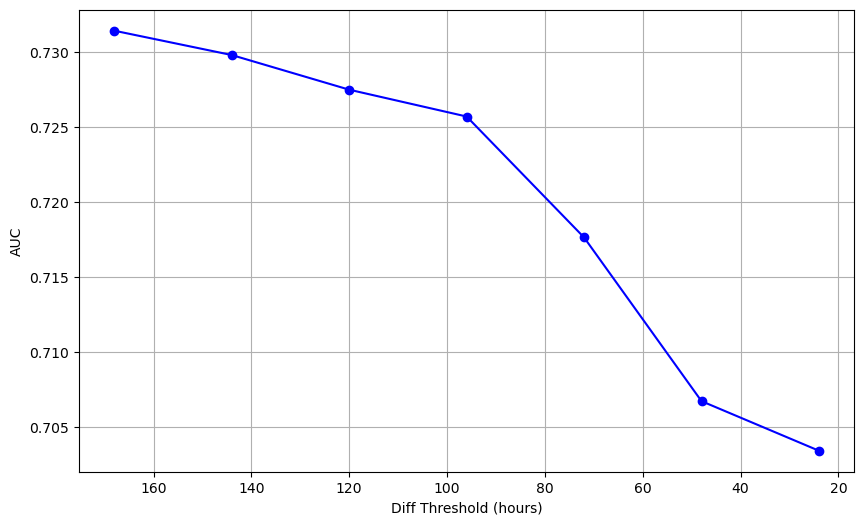

In [186]:
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# List of thresholds for 'Diff'
thresholds = [7*24, 6*24, 5*24, 4*24, 3*24, 2*24, 1*24]

auc_values = []

# Iterate over thresholds to evaluate the performance
for threshold in thresholds:
    subset_df = test_df[(test_df['label'] == 0) | ((test_df['label'] == 1) & (test_df['Diff'] < threshold))]
    subset_name = f"Diff < {threshold}"
    
    y_pred_classes_optimized = np.array(subset_df['predicted_label'].values)
    y_pred_prob = np.array(subset_df['predicted_prob'].values).ravel()
    y_true = np.array(subset_df['label'].values).astype(int)

    auc = roc_auc_score(y_true, y_pred_prob)
    accuracy = accuracy_score(y_true, y_pred_classes_optimized)
    precision = precision_score(y_true, y_pred_classes_optimized)
    recall = recall_score(y_true, y_pred_classes_optimized)
    f1 = calculate_f1(precision, recall)

    auc_values.append(auc)
    
    print(f"{subset_name}: AUC: {auc:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

# Plotting the AUC values against the thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, auc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Diff Threshold (hours)')
plt.ylabel('AUC')
plt.gca().invert_xaxis()  # Invert x-axis to show decreasing thresholds from left to right
plt.grid(True)
plt.show()